# 1. Introduction

In such a large and heterogenous city like Toronto it might be difficult to figure out what neighbourhoods to concentrate on in one's search to buy a new house. Particularly, considering the current high house prices in certain areas of the city. When searching for a house with family in mind, one has to concentrate neighbourhoods with low crime rates, average density of population, access to park and playgrounds, as well as restaurants and coffee shops. All of those creteria are usually considered with a certain budget in mind. This report is a case study thats takes Forest Hill South neighbourhood as a point of reference for a comfortable, safe, enjoyable living (our case subject, myself, is currently renting an apartment here), and tries to find other neighbourhoods in Toronto that are similar to Forest Hill South, but are more effordable (i.e., have an average home price of less than 800,000 dollars) for our suject to be able to go from renting to owning a house (average home price in Forest Hill South was $1.23 mil in 2017, see below).


In [517]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# 2. Crime data, population density and boundar coordinates data were obtained from Toronto Police Open Data Portal:
https://data.torontopolice.on.ca/datasets/af500b5abb7240399853b35a2362d0c0_0?geometry=-80.098%2C43.542%2C-78.659%2C43.890

### Reading the geojson file:

In [530]:
with open('Neighbourhood_Crime_Rates_Boundary_File_.geojson') as json_data:
    toronto_crime_json = json.load(json_data)

In [531]:
toronto_crime_json

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 1,
    'Neighbourhood_Crime_Rates_Neigh': 'Yonge-St.Clair',
    'Neighbourhood_Crime_Rates_Hood_': '097',
    'Hood_ID': 97,
    'Neighbourhood': 'Yonge-St.Clair',
    'Assault_2014': 58,
    'Assault_2015': 38,
    'Assault_2016': 51,
    'Assault_2017': 46,
    'Assault_2018': 61,
    'Assault_AVG': 50.8,
    'Assault_CHG': '33%',
    'Assault_Rate_2018': 1912.8,
    'Auto_Theft_2014': 28,
    'Auto_Theft_2015': 32,
    'Auto_Theft_2016': 22,
    'Auto_Theft_2017': 46,
    'Auto_Theft_2018': 69,
    'AutoTheft_AVG': 39.4,
    'AutoTheft_CHG': '50%',
    'AutoTheft_Rate_2018': 2163.7,
    'BreakandEnter_2014': 29,
    'BreakandEnter_2015': 16,
    'BreakandEnter_2016': 28,
    'BreakandEnter_2017': 32,
    'BreakandEnter_2018': 23,
    'BreakandEnter_AVG': 25.6,
    'BreakandEnter_CHG': '-28%',
    'BreakandEnter_Rate_2018': 721.2,
    'Robbery_2014': 12,
    'Robbery_2015': 25,
    'Robbery_

In [4]:
toronto_crime = toronto_crime_json['features']

In [5]:
toronto_crime[0]

{'type': 'Feature',
 'properties': {'OBJECTID': 1,
  'Neighbourhood_Crime_Rates_Neigh': 'Yonge-St.Clair',
  'Neighbourhood_Crime_Rates_Hood_': '097',
  'Hood_ID': 97,
  'Neighbourhood': 'Yonge-St.Clair',
  'Assault_2014': 58,
  'Assault_2015': 38,
  'Assault_2016': 51,
  'Assault_2017': 46,
  'Assault_2018': 61,
  'Assault_AVG': 50.8,
  'Assault_CHG': '33%',
  'Assault_Rate_2018': 1912.8,
  'Auto_Theft_2014': 28,
  'Auto_Theft_2015': 32,
  'Auto_Theft_2016': 22,
  'Auto_Theft_2017': 46,
  'Auto_Theft_2018': 69,
  'AutoTheft_AVG': 39.4,
  'AutoTheft_CHG': '50%',
  'AutoTheft_Rate_2018': 2163.7,
  'BreakandEnter_2014': 29,
  'BreakandEnter_2015': 16,
  'BreakandEnter_2016': 28,
  'BreakandEnter_2017': 32,
  'BreakandEnter_2018': 23,
  'BreakandEnter_AVG': 25.6,
  'BreakandEnter_CHG': '-28%',
  'BreakandEnter_Rate_2018': 721.2,
  'Robbery_2014': 12,
  'Robbery_2015': 25,
  'Robbery_2016': 14,
  'Robbery_2017': 21,
  'Robbery_2018': 19,
  'Robbery_AVG': 18.2,
  'Robbery_CHG': '-10%',
  'Ro

In [532]:
column_names = ['Neighbourhood', 'Assault_Rate_2018', 
                'AutoTheft_Rate_2018', 'BreakandEnter_Rate_2018', 
                'Robbery_Rate_2018', 'Homicide_Rate_2018', 'Population', "Size_of_hood_area",
                "Latitude","Longitude"]

In [533]:
hood_crime = pd.DataFrame(columns=column_names)
hood_crime

Empty DataFrame
Columns: [Neighbourhood, Assault_Rate_2018, AutoTheft_Rate_2018, BreakandEnter_Rate_2018, Robbery_Rate_2018, Homicide_Rate_2018, Population, Size_of_hood_area, Latitude, Longitude]
Index: []

### Extracting the following properties from the geojson file: 'Neighbourhood', 'Assault_Rate_2018', 'AutoTheft_Rate_2018', 'BreakandEnter_Rate_2018', 'Robbery_Rate_2018', 'Homicide_Rate_2018', 'Population', "Size_of_hood_area", "Latitude", "Longitude", and converting boundary data into the central coordinates point for each neighbourhood.

In [534]:
for data in toronto_crime: 
    neighborhood = data['properties']['Neighbourhood']
    assault = data['properties']['Assault_Rate_2018']
    auto_theft = data['properties']['AutoTheft_Rate_2018']
    breakandenter = data['properties']['BreakandEnter_Rate_2018']
    robbery = data['properties']['Robbery_Rate_2018']
    homicide = data['properties']['Homicide_Rate_2018']
    population = data['properties']['Population']
    area = data["properties"]['Shape__Area']
    lats = []
    lons = []
    neighborhood_latlon_boundary = data['geometry']['coordinates']
    for item in neighborhood_latlon_boundary[0]:
        lats.append(item[1])
        lons.append(item[0])
    neighborhood_lat = np.array(lats).mean()
    neighborhood_lon = np.array(lons).mean()
    hood_crime = hood_crime.append({'Neighbourhood': neighborhood,
                                          'Assault_Rate_2018': assault,
                                          'AutoTheft_Rate_2018': auto_theft,
                                          'BreakandEnter_Rate_2018': breakandenter,
                                          'Robbery_Rate_2018': robbery,
                                          'Homicide_Rate_2018': homicide,
                                          'Population': population,
                                            "Size_of_hood_area": area,
                                        "Latitude": neighborhood_lat,
                                   "Longitude": neighborhood_lon}, ignore_index=True)

In [536]:
hood_crime[0:10]

Neighbourhood  Assault_Rate_2018  AutoTheft_Rate_2018  \
0                Yonge-St.Clair             1912.8               2163.7   
1       York University Heights              375.4                 62.6   
2              Lansing-Westgate             1923.5                214.8   
3            Yorkdale-Glen Park              696.5                153.6   
4           Stonegate-Queensway              576.4                184.6   
5        Tam O'Shanter-Sullivan              128.2                105.3   
6                   The Beaches             1610.4                 77.5   
7  Thistletown-Beaumond Heights              187.0                155.9   
8              Thorncliffe Park             1616.4               1364.9   
9            Danforth East York             2165.0               1487.8   

   BreakandEnter_Rate_2018  Robbery_Rate_2018 Homicide_Rate_2018 Population  \
0                    721.2              595.8                  0       3189   
1                    141.4               40.8                2.7      36764   
2                    507.7              400.3                  0      10242   
3                    307.1              192.0                 11      18233   
4                    184.6              162.1                  0      22207   
5                     41.2               25.2                2.3      43695   
6                    831.6              274.9                  0      28378   
7                    155.9               49.9               12.5      16039   
8                    718.4              502.9                  0       8352   
9                   1096.8              314.7                  0      10485   

   Size_of_hood_area   Latitude  Longitude  
0       1.161315e+06  43.688762 -79.399013  
1       1.324666e+07  43.759661 -79.499115  
2       5.346186e+06  43.753880 -79.422502  
3       6.038326e+06  43.717458 -79.452711  
4       7.946202e+06  43.636838 -79.496012  
5       5.422345e+06  43.779365 -79.306608  
6       3.595829e+06  43.668305 -79.294287  
7       3.339481e+06  43.737721 -79.558346  
8       3.126554e+06  43.707124 -79.348242  
9       2.188598e+06  43.689215 -79.331051

### Creating Toronto Map using Folium.

In [10]:
import folium
latitude = 43.697786
longitude = -79.362862
toronto_crime_map = folium.Map(location=[latitude, longitude], zoom_start=11)

In [537]:
toronto_crime_map

In [13]:
from folium.features import DivIcon
from folium import IFrame

### Plotting Neighbourhoods using Population as Circle size 

In [538]:
# create map of New York using latitude and longitude values
toronto_hood_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, population in zip(hood_crime['Latitude'], 
                                              hood_crime['Longitude'], 
                                              hood_crime['Neighbourhood'],
                                             hood_crime['Population']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=np.sqrt(population/300),
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_hood_map)  

folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.08)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),

        html='<div style="font-size: 12pt">Circle Area = Population of Neighbourhood </div>',
        )
    ).add_to(toronto_hood_map)

text = 'Forest Hill South'

iframe = folium.IFrame(text, width=20, height=15)
popup = folium.Popup(iframe, max_width=3000, show=True)

# Text = folium.Marker(location=[43.694286, -79.412848], popup=popup,
#                      icon=folium.Icon(icon_color='green'))
# toronto_hood_map.add_child(Text)
# toronto_hood_map

toronto_hood_map

In [539]:
hood_crime.columns

Index(['Neighbourhood', 'Assault_Rate_2018', 'AutoTheft_Rate_2018',
       'BreakandEnter_Rate_2018', 'Robbery_Rate_2018', 'Homicide_Rate_2018',
       'Population', 'Size_of_hood_area', 'Latitude', 'Longitude'],
      dtype='object')

### Creating "per capita" variables for each crime feature.

In [540]:
hood_crime["Assault_per_capita"] = hood_crime['Assault_Rate_2018']/hood_crime['Population']
hood_crime["AutoTheft_per_capita"] = hood_crime['AutoTheft_Rate_2018']/hood_crime['Population']
hood_crime['BreakandEnter_per_capita'] = hood_crime['BreakandEnter_Rate_2018']/hood_crime['Population']
hood_crime['Robbery_per_capita'] = hood_crime['Robbery_Rate_2018']/hood_crime['Population']
hood_crime['Homicide_per_capita'] = hood_crime['Homicide_Rate_2018']/hood_crime['Population']


### Plotting Neighbourhoods using "Robbery_per_capita" as Circle size 

In [541]:
# create map of New York using latitude and longitude values
toronto_hood_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, robbery in zip(hood_crime['Latitude'], 
                                              hood_crime['Longitude'], 
                                              hood_crime['Neighbourhood'],
                                             hood_crime['Robbery_per_capita']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=np.sqrt(robbery*3000),
        popup=label,
        color='black',
        fill=True,
        fill_color='grey',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_hood_map)  
folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.15)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),

        html='<div style="font-size: 12pt">Circle Area = Robbery per capita </div>',
        )
    ).add_to(toronto_hood_map)


toronto_hood_map

### Plotting Neighbourhoods using "Assault_per_capita" as Circle size 

In [542]:
# create map of New York using latitude and longitude values
toronto_hood_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, crime in zip(hood_crime['Latitude'], 
                                              hood_crime['Longitude'], 
                                              hood_crime['Neighbourhood'],
                                             hood_crime['Assault_per_capita']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=np.sqrt(crime*500),
        popup=label,
        color='black',
        fill=True,
        fill_color='grey',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_hood_map)  
folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.15)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),

        html='<div style="font-size: 12pt">Circle Area = Assault per capita </div>',
        )
    ).add_to(toronto_hood_map)


toronto_hood_map

### Cleaning the dataframe, exploring features

In [546]:
hood_crime.drop(['Assault_Rate_2018', 'AutoTheft_Rate_2018',
       'BreakandEnter_Rate_2018', 'Robbery_Rate_2018', 'Homicide_Rate_2018'], axis=1, inplace=True)

In [547]:
hood_crime["Population_Density"] = hood_crime["Population"]/hood_crime["Size_of_hood_area"]*1000

In [548]:
hood_crime.head()

Neighbourhood Population  Size_of_hood_area   Latitude  \
0           Yonge-St.Clair       3189       1.161315e+06  43.688762   
1  York University Heights      36764       1.324666e+07  43.759661   
2         Lansing-Westgate      10242       5.346186e+06  43.753880   
3       Yorkdale-Glen Park      18233       6.038326e+06  43.717458   
4      Stonegate-Queensway      22207       7.946202e+06  43.636838   

   Longitude Assault_per_capita AutoTheft_per_capita BreakandEnter_per_capita  \
0 -79.399013           0.599812             0.678489                 0.226152   
1 -79.499115          0.0102111           0.00170275               0.00384615   
2 -79.422502           0.187805            0.0209725                0.0495704   
3 -79.452711             0.0382           0.00842429                0.0168431   
4 -79.496012          0.0259558           0.00831269               0.00831269   

  Robbery_per_capita Homicide_per_capita Population_Density  
0            0.18683                   0            2.74603  
1         0.00110978         7.34414e-05            2.77534  
2          0.0390842                   0            1.91576  
3          0.0105304         0.000603302            3.01955  
4          0.0072995                   0            2.79467

In [550]:
from scipy import stats
stats.pearsonr(hood_crime["Population_Density"], hood_crime["Assault_per_capita"])

(-0.2262069593676606, 0.007200028178117193)

Text(0.5, 0, 'Population Density')

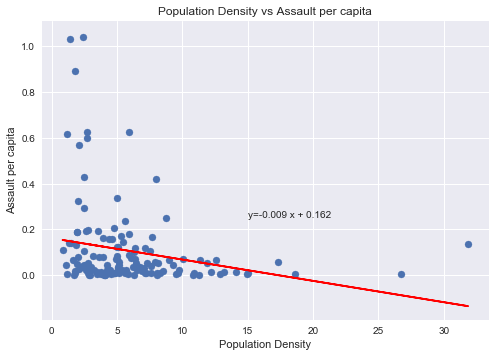

In [552]:
fit = np.polyfit(hood_crime["Population_Density"].astype(float), hood_crime['Assault_per_capita'].astype(float), deg=1)
plt.scatter(hood_crime["Population_Density"], hood_crime['Assault_per_capita'])
plt.plot(hood_crime["Population_Density"], fit[0] * hood_crime["Population_Density"] + fit[1], color='red') # recall that x is the Years
plt.annotate('y={0:.3f} x + {1:.3f}'.format(fit[0], fit[1]), xy=(15,.25))
plt.title("Population Density vs Assault per capita")
plt.ylabel("Assault per capita")
plt.xlabel("Population Density")

In [551]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(hood_crime["Population_Density"].astype(float), hood_crime['Assault_per_capita'].astype(float))
p_value


0.007200028178117155

### PLotting Neighbourhoods where the Circle Size represents Population_Density

In [553]:
# create map of Toronto using latitude and longitude values
toronto_hood_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, pop_density in zip(hood_crime['Latitude'], 
                                              hood_crime['Longitude'], 
                                              hood_crime['Neighbourhood'],
                                             hood_crime['Population_Density']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=np.sqrt(pop_density*10),
        popup=label,
        color='#805B13',
        fill=True,
        fill_color='#E9A625',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_hood_map)  

folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.15)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),

        html='<div style="font-size: 12pt">Circle Area = Population Density </div>',
        )
    ).add_to(toronto_hood_map)
    
toronto_hood_map

In [49]:
hood_crime.columns

Index(['Neighbourhood', 'Population', 'Size_of_hood_area', 'Latitude',
       'Longitude', 'Assault_per_capita', 'AutoTheft_per_capita',
       'BreakandEnter_per_capita', 'Robbery_per_capita', 'Homicide_per_capita',
       'Population_Density'],
      dtype='object')

### Querying Foursquare API for information about nearby venues for each neighbourhood

In [147]:
CLIENT_ID = 'XBKAMGZV4HLRWQMNFW3YEDMRI53AJKF3NZKMONCMNO1FAQDY' # your Foursquare ID
CLIENT_SECRET = 'VDMT1QTHUQK3V3P3S42FV2NQFKS50ZCX455T0UQAS4LEH5R0' # your Foursquare Secret
LIMIT = 100
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XBKAMGZV4HLRWQMNFW3YEDMRI53AJKF3NZKMONCMNO1FAQDY
CLIENT_SECRET:VDMT1QTHUQK3V3P3S42FV2NQFKS50ZCX455T0UQAS4LEH5R0


In [148]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [149]:
toronto_venues = getNearbyVenues(names=hood_crime['Neighbourhood'],
                                   latitudes=hood_crime['Latitude'],
                                   longitudes=hood_crime['Longitude']
                                  )

Yonge-St.Clair
York University Heights
Lansing-Westgate
Yorkdale-Glen Park
Stonegate-Queensway
Tam O'Shanter-Sullivan
The Beaches
Thistletown-Beaumond Heights
Thorncliffe Park
Danforth East York
Humewood-Cedarvale
Islington-City Centre West
Danforth
Rustic
Scarborough Village
South Parkdale
South Riverdale
St.Andrew-Windfields
Taylor-Massey
Humber Summit
Humbermede
Centennial Scarborough
Church-Yonge Corridor
Clairlea-Birchmount
Cliffcrest
Flemingdon Park
Corso Italia-Davenport
Ionview
Junction Area
Broadview North
Princess-Rosethorn
North Riverdale
Etobicoke West Mall
Forest Hill North
Glenfield-Jane Heights
Greenwood-Coxwell
Guildwood
Trinity-Bellwoods
Victoria Village
Waterfront Communities-The Island
West Hill
West Humber-Clairville
Westminster-Branson
Kennedy Park
Kingsview Village-The Westway
Bayview Woods-Steeles
Clanton Park
Keelesdale-Eglinton West
O'Connor-Parkview
Old East York
Casa Loma
Kensington-Chinatown
Kingsway South
Runnymede-Bloor West Village
Forest Hill South
Henry

In [150]:
print(toronto_venues.shape)
toronto_venues.head(10)

(10922, 7)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Yonge-St.Clair               43.688762               -79.399013   
1  Yonge-St.Clair               43.688762               -79.399013   
2  Yonge-St.Clair               43.688762               -79.399013   
3  Yonge-St.Clair               43.688762               -79.399013   
4  Yonge-St.Clair               43.688762               -79.399013   
5  Yonge-St.Clair               43.688762               -79.399013   
6  Yonge-St.Clair               43.688762               -79.399013   
7  Yonge-St.Clair               43.688762               -79.399013   
8  Yonge-St.Clair               43.688762               -79.399013   
9  Yonge-St.Clair               43.688762               -79.399013   

                   Venue  Venue Latitude  Venue Longitude     Venue Category  
0                   LCBO       43.686991       -79.399238       Liquor Store  
1        The Bagel House       43.687374       -79.393696         Bagel Shop  
2        Cava Restaurant       43.689809       -79.394932   Tapas Restaurant  
3           Waxon Waxbar       43.682824       -79.391971                Spa  
4              DAVIDsTEA       43.688376       -79.394158           Tea Room  
5            Scaramouche       43.681293       -79.399492  French Restaurant  
6  The Market By Longo’s       43.686711       -79.399536        Supermarket  
7          Boxcar Social       43.681750       -79.391447        Coffee Shop  
8                   LCBO       43.681497       -79.391261       Liquor Store  
9                  9bars       43.688660       -79.391940               Café

In [151]:
toronto_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  \
Neighbourhood                                                 
Agincourt North                                          63   
Agincourt South-Malvern West                            100   
Alderwood                                               100   
Annex                                                   100   
Banbury-Don Mills                                       100   
Bathurst Manor                                           47   
Bay Street Corridor                                     100   
Bayview Village                                          68   
Bayview Woods-Steeles                                    39   
Bedford Park-Nortown                                    100   
Beechborough-Greenbrook                                  67   
Bendale                                                  55   
Birchcliffe-Cliffside                                    21   
Black Creek                                              59   
Blake-Jones                                             100   
Briar Hill-Belgravia                                     83   
Bridle Path-Sunnybrook-York Mills                        37   
Broadview North                                         100   
Brookhaven-Amesbury                                      54   
Cabbagetown-South St.James Town                         100   
Caledonia-Fairbank                                      100   
Casa Loma                                               100   
Centennial Scarborough                                   23   
Church-Yonge Corridor                                   100   
Clairlea-Birchmount                                      52   
Clanton Park                                             55   
Cliffcrest                                               42   
Corso Italia-Davenport                                  100   
Danforth                                                100   
Danforth East York                                      100   
Don Valley Village                                       97   
Dorset Park                                             100   
Dovercourt-Wallace Emerson-Junction                     100   
Downsview-Roding-CFB                                     54   
Dufferin Grove                                          100   
East End-Danforth                                       100   
Edenbridge-Humber Valley                                 39   
Eglinton East                                            49   
Elms-Old Rexdale                                         52   
Englemount-Lawrence                                     100   
Eringate-Centennial-West Deane                           51   
Etobicoke West Mall                                      60   
Flemingdon Park                                          76   
Forest Hill North                                        84   
Forest Hill South                                       100   
Glenfield-Jane Heights                                   38   
Greenwood-Coxwell                                       100   
Guildwood                                                14   
Henry Farm                                              100   
High Park North                                         100   
High Park-Swansea                                       100   
Highland Creek                                           20   
Hillcrest Village                                        87   
Humber Heights-Westmount                                 39   
Humber Summit                                            21   
Humbermede                                               34   
Humewood-Cedarvale                                      100   
Ionview                                                 100   
Islington-City Centre West                              100   
Junction Area                                           100   
Keelesdale-Eglinton West                                 92   
Kennedy Park                                             50   
Kensi

In [152]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 347 uniques categories.


### One-hot encoding of venue category data

In [153]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

#move neighborhood column to the first column
fixed_columns = ["Neighbourhood"] + list(toronto_onehot.columns.difference(['Neighbourhood']))
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Neighbourhood  ATM  Accessories Store  Afghan Restaurant  \
0  Yonge-St.Clair    0                  0                  0   
1  Yonge-St.Clair    0                  0                  0   
2  Yonge-St.Clair    0                  0                  0   
3  Yonge-St.Clair    0                  0                  0   
4  Yonge-St.Clair    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    0   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    0   
4                   0        0               0                    0   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   0   
1            0                    0                 0                   0   
2            0                    0                 0                   0   
3            0                    0                 0                   0   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          0           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          0           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           0       0     0    0               0                 0   
1           1       0     0    0               0                 0   
2           0       0     0    0               0                 0   
3           0       0     0    0               0                 0   
4           0       0     0    0               0                 0   

   Basketball Court  Basketball Stadium  Bath House  Beach  Beach Bar  \
0                 0                   0           0      0          0   
1                 0                   0           0      0          0   
2                 0                   0           0      0          0   
3                 0                   0           0      0          0   
4                 0                   0           0      0          0   

   Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  Big Box Store  \
0         0            0           0                   0              0   
1         0            0           0                   0              0   
2         0            0           0                   0              0   
3         0            0           0                   0              0   
4         0            0           0                   0              0   

   Bike Shop  Bistro  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0          0       0              0          0                 0         0   
1          0       0              0          0                 0         0   
2          0       0              0          0                 0         0   
3          0       0              0          0                 0         0   
4          0       0              0          0                 0         0   

   Bowling Alley  Brazi

In [154]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').sum().reset_index()
toronto_grouped.shape

(140, 348)

### Merge Crime Data with Venue Data

In [155]:
crime_venues = hood_crime.merge(toronto_grouped, on ="Neighbourhood", how="left")

In [156]:
crime_venues.head()

Neighbourhood Population  Size_of_hood_area   Latitude  \
0           Yonge-St.Clair       3189       1.161315e+06  43.688762   
1  York University Heights      36764       1.324666e+07  43.759661   
2         Lansing-Westgate      10242       5.346186e+06  43.753880   
3       Yorkdale-Glen Park      18233       6.038326e+06  43.717458   
4      Stonegate-Queensway      22207       7.946202e+06  43.636838   

   Longitude Assault_per_capita AutoTheft_per_capita BreakandEnter_per_capita  \
0 -79.399013           0.599812             0.678489                 0.226152   
1 -79.499115          0.0102111           0.00170275               0.00384615   
2 -79.422502           0.187805            0.0209725                0.0495704   
3 -79.452711             0.0382           0.00842429                0.0168431   
4 -79.496012          0.0259558           0.00831269               0.00831269   

  Robbery_per_capita Homicide_per_capita Population_Density  ATM  \
0            0.18683                   0            2.74603    0   
1         0.00110978         7.34414e-05            2.77534    0   
2          0.0390842                   0            1.91576    0   
3          0.0105304         0.000603302            3.01955    0   
4          0.0072995                   0            2.79467    0   

   Accessories Store  Afghan Restaurant  African Restaurant  Airport  \
0                  0                  0                   0        0   
1                  0                  0                   0        0   
2                  0                  0                   0        0   
3                  1                  0                   0        0   
4                  0                  0                   0        0   

   Airport Lounge  American Restaurant  Amphitheater  Antique Shop  Aquarium  \
0               0                    3             0             0         0   
1               0                    0             0             0         0   
2               0                    0             0             0         0   
3               0                    2             0             0         0   
4               0                    1             0             0         0   

   Arcade  Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0       0                       0            0                    0   
1       0                       0            0                    0   
2       0                       0            0                    1   
3       0                       0            0                    1   
4       0                       0            0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Automotive Shop  \
0                 0                   1                0                0   
1                 0                   1                0                0   
2                 0                   0                0                0   
3                 0                   1                0                0   
4                 0                   0                0                0   

   BBQ Joint  Baby Store  Badminton Court  Bagel Shop  Bakery  Bank  Bar  \
0          2           0                0           2       0     0    1   
1          0           0                0           0       0     1    2   
2          0           0                0           0       1     2    1   
3          0           0                0           0       0     1    0   
4          1           0                0           0       2     4    2   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0         

In [157]:
crime_venues.replace(np.nan, 0.0, inplace=True)

In [158]:
crime_venues.head()

Neighbourhood  Population  Size_of_hood_area   Latitude  \
0           Yonge-St.Clair        3189       1.161315e+06  43.688762   
1  York University Heights       36764       1.324666e+07  43.759661   
2         Lansing-Westgate       10242       5.346186e+06  43.753880   
3       Yorkdale-Glen Park       18233       6.038326e+06  43.717458   
4      Stonegate-Queensway       22207       7.946202e+06  43.636838   

   Longitude  Assault_per_capita  AutoTheft_per_capita  \
0 -79.399013            0.599812              0.678489   
1 -79.499115            0.010211              0.001703   
2 -79.422502            0.187805              0.020972   
3 -79.452711            0.038200              0.008424   
4 -79.496012            0.025956              0.008313   

   BreakandEnter_per_capita  Robbery_per_capita  Homicide_per_capita  \
0                  0.226152            0.186830             0.000000   
1                  0.003846            0.001110             0.000073   
2                  0.049570            0.039084             0.000000   
3                  0.016843            0.010530             0.000603   
4                  0.008313            0.007300             0.000000   

   Population_Density  ATM  Accessories Store  Afghan Restaurant  \
0            2.746026    0                  0                  0   
1            2.775342    0                  0                  0   
2            1.915758    0                  0                  0   
3            3.019546    0                  1                  0   
4            2.794669    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    3   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    2   
4                   0        0               0                    1   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   1   
1            0                    0                 0                   1   
2            0                    1                 0                   0   
3            0                    1                 0                   1   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          2           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          1           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           2       0     0    1               0                 0   
1           0       0     1    2               0                 0   
2           0       1     2    1               0                 0   
3           0       0     1    0               0                 0   
4           0       2     4    2               0                 0   

   Basketball Court  Basketball Stadium  Bath House  Beach  Beach Bar  \
0                 0                   0           0      0          0   
1     

In [159]:
crime_venues.columns

Index(['Neighbourhood', 'Population', 'Size_of_hood_area', 'Latitude',
       'Longitude', 'Assault_per_capita', 'AutoTheft_per_capita',
       'BreakandEnter_per_capita', 'Robbery_per_capita', 'Homicide_per_capita',
       ...
       'Vietnamese Restaurant', 'Warehouse Store', 'Whisky Bar', 'Wine Bar',
       'Wings Joint', 'Women's Store', 'Xinjiang Restaurant', 'Yoga Studio',
       'Zoo', 'Zoo Exhibit'],
      dtype='object', length=358)

# Create the Feature Dataset

In [160]:
X_orig = crime_venues.drop(['Neighbourhood', 
                            'Population', 'Size_of_hood_area', 'Latitude', 'Longitude'], axis=1)

In [161]:
X_orig.head()

Assault_per_capita  AutoTheft_per_capita  BreakandEnter_per_capita  \
0            0.599812              0.678489                  0.226152   
1            0.010211              0.001703                  0.003846   
2            0.187805              0.020972                  0.049570   
3            0.038200              0.008424                  0.016843   
4            0.025956              0.008313                  0.008313   

   Robbery_per_capita  Homicide_per_capita  Population_Density  ATM  \
0            0.186830             0.000000            2.746026    0   
1            0.001110             0.000073            2.775342    0   
2            0.039084             0.000000            1.915758    0   
3            0.010530             0.000603            3.019546    0   
4            0.007300             0.000000            2.794669    0   

   Accessories Store  Afghan Restaurant  African Restaurant  Airport  \
0                  0                  0                   0        0   
1                  0                  0                   0        0   
2                  0                  0                   0        0   
3                  1                  0                   0        0   
4                  0                  0                   0        0   

   Airport Lounge  American Restaurant  Amphitheater  Antique Shop  Aquarium  \
0               0                    3             0             0         0   
1               0                    0             0             0         0   
2               0                    0             0             0         0   
3               0                    2             0             0         0   
4               0                    1             0             0         0   

   Arcade  Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0       0                       0            0                    0   
1       0                       0            0                    0   
2       0                       0            0                    1   
3       0                       0            0                    1   
4       0                       0            0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Automotive Shop  \
0                 0                   1                0                0   
1                 0                   1                0                0   
2                 0                   0                0                0   
3                 0                   1                0                0   
4                 0                   0                0                0   

   BBQ Joint  Baby Store  Badminton Court  Bagel Shop  Bakery  Bank  Bar  \
0          2           0                0           2       0     0    1   
1          0           0                0           0       0     1    2   
2          0           0                0           0       1     2    1   
3          0           0                0           0       0     1    0   
4          1           0                0           0       2     4    2   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Bath House  Beach  Beach Bar  Beer Bar  Beer Garden  Beer Store  \
0           0      0          0         0            0           0   
1           0      0          0         0            0           1   
2           0      0          0         0            0           0   
3           0      0          0         0            0           0   
4           0      0          0         0            0         

### Normalizing the features and scaling down the weights of crime (to 1/5) and venue category (1/347) features

In [162]:
from sklearn.preprocessing import StandardScaler

X_norm = StandardScaler().fit_transform(X_orig)
X_norm

array([[ 2.68883342e+00,  8.08319809e+00,  1.26690664e+00, ...,
         1.04330119e+00, -1.20385853e-01, -8.48188930e-02],
       [-5.28361782e-01, -3.69631069e-01, -3.56719898e-01, ...,
        -5.44331054e-01, -1.20385853e-01, -8.48188930e-02],
       [ 4.40691714e-01, -1.28958766e-01, -2.27702438e-02, ...,
         1.04330119e+00, -1.20385853e-01, -8.48188930e-02],
       ...,
       [-4.49115979e-01, -2.42495450e-01, -3.12199300e-01, ...,
         1.04330119e+00, -1.20385853e-01, -8.48188930e-02],
       [ 1.76527536e+00,  7.44427034e-01, -4.63165684e-04, ...,
        -5.44331054e-01, -1.20385853e-01, -8.48188930e-02],
       [-5.67115281e-01, -3.74485138e-01, -3.37655743e-01, ...,
        -5.44331054e-01, -1.20385853e-01, -8.48188930e-02]])

In [163]:
X_norm.shape

(140, 353)

In [164]:
weight1 = np.ones((5,))
weight1 = weight1 / 5
weight2 = list(weight1) + [1]
weight3 = np.ones((347,))
weight3 = weight3 / 347
weight3[0:10]

array([0.00288184, 0.00288184, 0.00288184, 0.00288184, 0.00288184,
       0.00288184, 0.00288184, 0.00288184, 0.00288184, 0.00288184])

In [165]:
weights = np.array(list(weight2) + list(weight3))
weights[0:10]

array([0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       1.        , 0.00288184, 0.00288184, 0.00288184, 0.00288184])

In [166]:
X_norm = X_norm*weights

In [167]:
X_norm

array([[ 5.37766684e-01,  1.61663962e+00,  2.53381328e-01, ...,
         3.00663166e-03, -3.46933294e-04, -2.44434850e-04],
       [-1.05672356e-01, -7.39262138e-02, -7.13439795e-02, ...,
        -1.56867739e-03, -3.46933294e-04, -2.44434850e-04],
       [ 8.81383428e-02, -2.57917533e-02, -4.55404875e-03, ...,
         3.00663166e-03, -3.46933294e-04, -2.44434850e-04],
       ...,
       [-8.98231959e-02, -4.84990900e-02, -6.24398601e-02, ...,
         3.00663166e-03, -3.46933294e-04, -2.44434850e-04],
       [ 3.53055073e-01,  1.48885407e-01, -9.26331367e-05, ...,
        -1.56867739e-03, -3.46933294e-04, -2.44434850e-04],
       [-1.13423056e-01, -7.48970276e-02, -6.75311485e-02, ...,
        -1.56867739e-03, -3.46933294e-04, -2.44434850e-04]])

### Testing the number of clusters to be used in final analysis using the distortion function

In [227]:
distortions = []
ks = []
for kclusters in range (1,10):
    kmeans = KMeans(n_clusters=kclusters, random_state=21).fit(X_norm)
    ks.append(kclusters)
    distortions.append(kmeans.inertia_)
    ks_distortions = pd.DataFrame({'Number of Clusters': ks, 'Distortion': distortions})
ks_distortions

Number of Clusters  Distortion
0                   1  168.403458
1                   2   86.178619
2                   3   57.331755
3                   4   41.576499
4                   5   29.363811
5                   6   23.483741
6                   7   19.838553
7                   8   16.936755
8                   9   15.097264

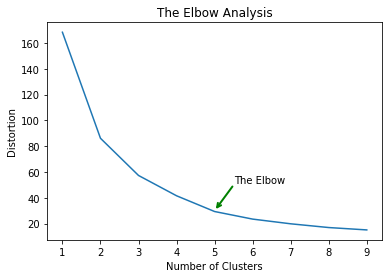

In [238]:
import matplotlib.pylab as plt
plt.plot(ks_distortions["Number of Clusters"], ks_distortions["Distortion"])
plt.title("The Elbow Analysis")
plt.ylabel("Distortion")
plt.xlabel("Number of Clusters")
plt.annotate('',                      # s: str. will leave it blank for no text
             xy=(5, 30),             # place head of the arrow at point (year 2012 , pop 70)
             xytext=(5.5, 50),         # place base of the arrow at point (year 2008 , pop 20)
#              xycoords='data',         # will use the coordinate system of the object being annotated 
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='green', lw=2)
            )

# Annotate Text
plt.annotate('The Elbow', # text to display
             xy=(5.5, 50),                    # start the text at at point (year 2008 , pop 30)
#              rotation=72.5,                  # based on trial and error to match the arrow
             va='bottom',                    # want the text to be vertically 'bottom' aligned
             ha='left',                      # want the text to be horizontally 'left' algned.
            )




plt.show()

### Segmenting the data into the optimally chosen 5 clusters using k-means clustering

In [255]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=21).fit(X_norm)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)
print(kmeans.inertia_)

[3 0 0 0 0 4 4 0 0 0 4 0 1 0 0 1 0 0 4 0 0 0 2 0 0 4 4 4 3 0 0 0 3 4 0 4 0
 1 0 4 0 0 4 0 0 0 0 4 0 4 4 4 0 1 0 0 4 4 0 4 4 0 0 0 0 4 0 4 3 4 4 0 2 4
 4 1 0 0 3 0 0 4 0 0 0 0 0 1 0 0 1 0 3 4 0 1 0 0 4 1 1 1 4 3 0 0 4 0 4 3 0
 0 4 0 0 4 0 4 0 0 4 4 0 1 4 4 4 4 4 0 1 1 4 4 0 4 0 0 0 0]
29.363810872860665


### Adding Cluster Labels to the Original Dataset with crime and Venue data

In [169]:
cluster_crime_venues = crime_venues.copy()
cluster_crime_venues.insert(0, "Cluster Labels", kmeans.labels_)

### Plotting Clustered Neighbourhoods using Population Density as Circle Size.

In [322]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, density in zip(cluster_crime_venues['Latitude'], 
                                  cluster_crime_venues['Longitude'], 
                                  cluster_crime_venues['Neighbourhood'], 
                                  cluster_crime_venues['Cluster Labels'],
                                       cluster_crime_venues['Population_Density']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=np.sqrt(density*10),
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.15)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),

        html='<div style="font-size: 12pt">Circle Area = Population Density </div>',
        )
    ).add_to(map_clusters)
       
map_clusters

### Plotting Clustered Neighbourhoods using Coffee Shop count as Circle Size.

In [396]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, cafes in zip(cluster_crime_venues['Latitude'], 
                                  cluster_crime_venues['Longitude'], 
                                  cluster_crime_venues['Neighbourhood'], 
                                  cluster_crime_venues['Cluster Labels'],
                                       cluster_crime_venues['Coffee Shop']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=cafes,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.15)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),

        html='<div style="font-size: 12pt">Circle Radius = Number of Cafes </div>',
        )
    ).add_to(map_clusters)
       
map_clusters

### Plotting Clustered Neighbourhoods using Number of Parks as Circle Size.

In [557]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, parks in zip(cluster_crime_venues['Latitude'], 
                                  cluster_crime_venues['Longitude'], 
                                  cluster_crime_venues['Neighbourhood'], 
                                  cluster_crime_venues['Cluster Labels'],
                                       cluster_crime_venues['Park']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=parks*2,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
    
folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.15)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),

        html='<div style="font-size: 12pt">Circle Radius = Number of Parks </div>',
        )
    ).add_to(map_clusters)
       
map_clusters

# Obtaining and cleaning the data on Average Home Prices in Toronto in 2017, from the following blog post:
https://www.moneysense.ca/spend/real-estate/where-to-buy-2019-toronto/

In [96]:
house_prices_raw = pd.read_html("Where to buy real estate in Toronto in 2019 - MoneySense.html")

In [97]:
house_prices_raw[0]

Rank                        Neighbourhood         Area  \
0       1                    Rockcliffe-Smythe  Toronto W03   
1       2                        Humber Summit  Toronto W05   
2       3               Glenfield-Jane Heights  Toronto W05   
3       4             Keelesdale-Eglinton West  Toronto W03   
4       5                      Little Portugal  Toronto C01   
5       6                      Oakwood-Vaughan  Toronto C03   
6       7                         Mount Dennis  Toronto W04   
7       8                 Kensington-Chinatown  Toronto C01   
8       9                             Oakridge  Toronto E06   
9      10                          Black Creek  Toronto W05   
10     11                            West Hill  Toronto E10   
11     12                   Caledonia-Fairbank  Toronto W03   
12     13                     Woodbine-Lumsden  Toronto E03   
13     14                 Briar Hill-Belgravia  Toronto W04   
14     15                       Dufferin Grove  Toronto C01   
15     16                               Weston  Toronto W04   
16     17                               Woburn  Toronto E09   
17     18    Mount Olive-Silverstone-Jamestown  Toronto W10   
18     19                           Humbermede  Toronto W05   
19     20                        Eglinton East  Toronto E08   
20     21                              Malvern  Toronto E11   
21     22                         Kennedy Park  Toronto E04   
22     23                      Rexdale-Kipling  Toronto W10   
23     24              Humberlea-Pelmo Park W4  Toronto W04   
24     25                     Elms-Old Rexdale  Toronto W10   
25     26                        Crescent Town  Toronto E03   
26     27                            Moss Park  Toronto C08   
27     28     Cabbagetown-South St. James Town  Toronto C08   
28     29               West Humber-Clairville  Toronto W10   
29     30                       South Parkdale  Toronto W01   
30     31                  Clairlea-Birchmount  Toronto E04   
31     32                               Mimico  Toronto W06   
32     33                            East York  Toronto E03   
33     34           Danforth Village-East York  Toronto E03   
34     35                            Rouge E10  Toronto E10   
35     36              Palmerston-Little Italy  Toronto C01   
36     37        Thistletown-Beaumonde Heights  Toronto W10   
37     38                   Weston-Pellam Park  Toronto W03   
38     39              Beechborough-Greenbrook  Toronto W04   
39     40                  Etobicoke West Mall  Toronto W08   
40     41                              Bendale  Toronto E09   
41     42                    Trinity-Bellwoods  Toronto C01   
42     43                              Ionview  Toronto E04   
43     44                          Regent Park  Toronto C08   
44     45                    Greenwood-Coxwell  Toronto E01   
45     46                          New Toronto  Toronto W06   
46     47                  Englemount-Lawrence  Toronto C04   
47     48                            Alderwood  Toronto W06   
48     49                          Blake-Jones  Toronto E01   
49     50                    O'Connor-Parkview  Toronto E03   
50     51                           Cliffcrest  Toronto E08   
51     52                Birchcliffe-Cliffside  Toronto E06   
52     53                          Morningside  Toronto E09   
53     54                   Yorkdale-Glen Park  Toronto W04   
54     55       Eringate-Centennial-West Deane  Toronto W08   
55     56                           University  Toronto C01   
56     57                       Bathurst Manor  Toronto C06   
57     58                               Rustic  Toronto W04   
58     59                    Woodbine Corridor  Toronto E02   
59     60           Islington-City Centre West  Toronto W08   
60     61                          Long Branch  Toronto W06   
61     62                   Humewood-Cedarvale  Toronto C03   
62     63        Kingsview Village-T

In [98]:
house_prices = house_prices_raw[0].copy()

In [99]:
house_prices.columns

Index(['Rank', 'Neighbourhood', 'Area', 'Average home price  (2017)', 'Value',
       'Momentum', 'Average price vs. area', 'Avg. price vs. metro  district',
       'Avg. price vs. outer region', '1-year price change',
       '5-year price change', 'Final Star Rating'],
      dtype='object')

In [101]:
house_prices = house_prices[['Neighbourhood','Average home price  (2017)']]

In [102]:
house_prices.sort_values(by="Neighbourhood")[0:10]

Neighbourhood Average home price  (2017)
94                Agincourt North                   $873,976
118  Agincourt South-Malvern West                   $958,013
47                      Alderwood                   $873,114
63                          Annex                 $2,115,505
130             Banbury-Don Mills                 $1,199,256
56                 Bathurst Manor                   $933,915
79                Bayview Village                 $2,664,929
129         Bayview Woods-Steeles                 $1,199,256
71           Bedford Park-Nortown                   $908,743
38        Beechborough-Greenbrook                   $915,568

### Merging Average home prices dataset with the crime-and-venues data set with cluster labels

In [180]:
crime_venues_prices_cluster = cluster_crime_venues.merge(house_prices, on="Neighbourhood", how="left")

In [181]:
print(crime_venues_prices_cluster.shape, cluster_crime_venues.shape, house_prices.shape)

(140, 360) (140, 359) (134, 2)


In [182]:
crime_venues_prices_cluster['Average home price  (2017)'] = crime_venues_prices_cluster['Average home price  (2017)'].str.replace("$", "")

In [183]:
crime_venues_prices_cluster['Average home price  (2017)'] = crime_venues_prices_cluster['Average home price  (2017)'].str.replace(",", "")

In [184]:
crime_venues_prices_cluster["Average home price  (2017)"].head()

0        NaN
1    2621947
2    1685373
3     940929
4     822992
Name: Average home price  (2017), dtype: object

In [185]:
crime_venues_prices_cluster[
    'Average home price  (2017)'] = crime_venues_prices_cluster[
    'Average home price  (2017)'].astype(float)

In [186]:
crime_venues_prices_cluster[
    'Average home price  (2017)'] = crime_venues_prices_cluster[
    'Average home price  (2017)'].replace(
    np.nan, crime_venues_prices_cluster['Average home price  (2017)'].mean())

In [187]:
crime_venues_prices_cluster['Average home price  (2017)'].head()

0    1.275567e+06
1    2.621947e+06
2    1.685373e+06
3    9.409290e+05
4    8.229920e+05
Name: Average home price  (2017), dtype: float64

In [188]:
crime_venues_prices_cluster.head()

Cluster Labels            Neighbourhood  Population  Size_of_hood_area  \
0               3           Yonge-St.Clair        3189       1.161315e+06   
1               0  York University Heights       36764       1.324666e+07   
2               0         Lansing-Westgate       10242       5.346186e+06   
3               0       Yorkdale-Glen Park       18233       6.038326e+06   
4               0      Stonegate-Queensway       22207       7.946202e+06   

    Latitude  Longitude  Assault_per_capita  AutoTheft_per_capita  \
0  43.688762 -79.399013            0.599812              0.678489   
1  43.759661 -79.499115            0.010211              0.001703   
2  43.753880 -79.422502            0.187805              0.020972   
3  43.717458 -79.452711            0.038200              0.008424   
4  43.636838 -79.496012            0.025956              0.008313   

   BreakandEnter_per_capita  Robbery_per_capita  Homicide_per_capita  \
0                  0.226152            0.186830             0.000000   
1                  0.003846            0.001110             0.000073   
2                  0.049570            0.039084             0.000000   
3                  0.016843            0.010530             0.000603   
4                  0.008313            0.007300             0.000000   

   Population_Density  ATM  Accessories Store  Afghan Restaurant  \
0            2.746026    0                  0                  0   
1            2.775342    0                  0                  0   
2            1.915758    0                  0                  0   
3            3.019546    0                  1                  0   
4            2.794669    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    3   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    2   
4                   0        0               0                    1   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   1   
1            0                    0                 0                   1   
2            0                    1                 0                   0   
3            0                    1                 0                   1   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          2           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          1           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           2       0     0    1               0                 0   
1           0       0     1    2               0                 0   
2           0       1     2    1               0                 0   
3           0       0     1    0               0                 0   
4           0       2     4    2               0                 0   

   Basketball Court  Basketball Stadium  Bath 

## Plotting Average Home Prices as the size of circle of clustered Neighbourhoods.

In [558]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, house_price in zip(crime_venues_prices_cluster['Latitude'], 
                                  crime_venues_prices_cluster['Longitude'], 
                                  crime_venues_prices_cluster['Neighbourhood'], 
                                  crime_venues_prices_cluster['Cluster Labels'],
                                       crime_venues_prices_cluster['Average home price  (2017)']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + " $" + str(house_price), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=np.sqrt(house_price/20000),
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.15)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),

        html='<div style="font-size: 12pt">Circle Area = Average home price </div>',
        )
    ).add_to(map_clusters)
       
map_clusters

### Bar graph of home price by cluster

In [402]:
clusters_price_parks_cafes_yoga = pd.DataFrame(
    crime_venues_prices_cluster.groupby(
        "Cluster Labels", as_index=False)[
        "Cluster Labels","Average home price  (2017)", "Park", "Coffee Shop", "Yoga Studio"].describe())
price_parks_cafes_clusters

Cluster Labels                                     \
           count mean  std  min  25%  50%  75%  max   
0           72.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
2            2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0   
3            8.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0   
4           44.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0   

  Average home price  (2017)                                             \
                       count          mean            std           min   
0                       72.0  1.280714e+06  612025.700570  6.311980e+05   
1                       14.0  1.159847e+06  345918.770453  7.002040e+05   
2                        2.0  1.275567e+06       0.000000  1.275567e+06   
3                        8.0  1.321765e+06  875366.495505  7.300110e+05   
4                       44.0  1.295567e+06  676592.232818  7.014480e+05   

                                                           Park            \
            25%           50%           75%           max count      mean   
0  9.093632e+05  1.199256e+06  1.342285e+06  3.757271e+06  72.0  2.152778   
1  8.745495e+05  1.231132e+06  1.425431e+06  1.773134e+06  14.0  3.571429   
2  1.275567e+06  1.275567e+06  1.275567e+06  1.275567e+06   2.0  3.000000   
3  7.965662e+05  9.424165e+05  1.415977e+06  3.287905e+06   8.0  2.625000   
4  9.158448e+05  1.177368e+06  1.323422e+06  4.755258e+06  44.0  2.772727   

                                      Coffee Shop                           \
        std  min   25%  50%  75%  max       count      mean       std  min   
0  1.562408  0.0  1.00  2.0  3.0  7.0        72.0  6.027778  2.911716  1.0   
1  1.988981  1.0  2.00  3.0  5.0  7.0        14.0  6.642857  3.128213  2.0   
2  1.414214  2.0  2.50  3.0  3.5  4.0         2.0  5.000000  2.828427  3.0   
3  2.825269  0.0  0.75  1.0  6.0  6.0         8.0  5.375000  2.445842  2.0   
4  1.828249  0.0  2.00  2.5  4.0  7.0        44.0  6.704545  2.557065  3.0   

                        Yoga Studio                                          \
   25%  50%   75%   max       count      mean       std  min  25%  50%  75%   
0  4.0  6.0  8.00  13.0        72.0  0.208333  0.603686  0.0  0.0  0.0  0.0   
1  5.0  6.0  7.00  13.0        14.0  0.857143  0.770329  0.0  0.0  1.0  1.0   
2  4.0  5.0  6.00   7.0         2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
3  4.5  5.0  6.25  10.0         8.0  0.500000  0.755929  0.0  0.0  0.0  1.0   
4  5.0  7.0  8.00  13.0        44.0  0.340909  0.525763  0.0  0.0  0.0  1.0   

        
   max  
0  3.0  
1  2.0  
2  1.0  
3  2.0  
4  2.0

In [406]:
clusters_price_parks_cafes_yoga["Average home price  (2017)", "error"] = clusters_price_parks_cafes_yoga[
    "Average home price  (2017)", "std"]/ np.sqrt(clusters_price_parks_cafes_yoga["Average home price  (2017)", "count"])
clusters_price_parks_cafes_yoga["Park", "error"] = clusters_price_parks_cafes_yoga[
    "Park", "std"]/ np.sqrt(clusters_price_parks_cafes_yoga["Park", "count"])
clusters_price_parks_cafes_yoga["Coffee Shop", "error"] = clusters_price_parks_cafes_yoga[
    "Coffee Shop", "std"]/ np.sqrt(clusters_price_parks_cafes_yoga["Coffee Shop", "count"])
clusters_price_parks_cafes_yoga["Yoga Studio", "error"] = clusters_price_parks_cafes_yoga[
    "Yoga Studio", "std"]/ np.sqrt(clusters_price_parks_cafes_yoga["Yoga Studio", "count"])

In [407]:
clusters_price_parks_cafes_yoga

Cluster Labels                                     \
           count mean  std  min  25%  50%  75%  max   
0           72.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
2            2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0   
3            8.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0   
4           44.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0   

  Average home price  (2017)                                             \
                       count          mean            std           min   
0                       72.0  1.280714e+06  612025.700570  6.311980e+05   
1                       14.0  1.159847e+06  345918.770453  7.002040e+05   
2                        2.0  1.275567e+06       0.000000  1.275567e+06   
3                        8.0  1.321765e+06  875366.495505  7.300110e+05   
4                       44.0  1.295567e+06  676592.232818  7.014480e+05   

                                                           Park            \
            25%           50%           75%           max count      mean   
0  9.093632e+05  1.199256e+06  1.342285e+06  3.757271e+06  72.0  2.152778   
1  8.745495e+05  1.231132e+06  1.425431e+06  1.773134e+06  14.0  3.571429   
2  1.275567e+06  1.275567e+06  1.275567e+06  1.275567e+06   2.0  3.000000   
3  7.965662e+05  9.424165e+05  1.415977e+06  3.287905e+06   8.0  2.625000   
4  9.158448e+05  1.177368e+06  1.323422e+06  4.755258e+06  44.0  2.772727   

                                      Coffee Shop                           \
        std  min   25%  50%  75%  max       count      mean       std  min   
0  1.562408  0.0  1.00  2.0  3.0  7.0        72.0  6.027778  2.911716  1.0   
1  1.988981  1.0  2.00  3.0  5.0  7.0        14.0  6.642857  3.128213  2.0   
2  1.414214  2.0  2.50  3.0  3.5  4.0         2.0  5.000000  2.828427  3.0   
3  2.825269  0.0  0.75  1.0  6.0  6.0         8.0  5.375000  2.445842  2.0   
4  1.828249  0.0  2.00  2.5  4.0  7.0        44.0  6.704545  2.557065  3.0   

                        Yoga Studio                                          \
   25%  50%   75%   max       count      mean       std  min  25%  50%  75%   
0  4.0  6.0  8.00  13.0        72.0  0.208333  0.603686  0.0  0.0  0.0  0.0   
1  5.0  6.0  7.00  13.0        14.0  0.857143  0.770329  0.0  0.0  1.0  1.0   
2  4.0  5.0  6.00   7.0         2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
3  4.5  5.0  6.25  10.0         8.0  0.500000  0.755929  0.0  0.0  0.0  1.0   
4  5.0  7.0  8.00  13.0        44.0  0.340909  0.525763  0.0  0.0  0.0  1.0   

       Average home price  (2017)      Park Coffee Shop Yoga Studio  
   max                      error     error       error       error  
0  3.0               72127.920522  0.184132    0.343149    0.071145  
1  2.0               92450.680192  0.531577    0.836050    0.205879  
2  1.0                   0.000000  1.000000    2.000000    0.000000  
3  2.0              309488.792498  0.998883    0.864736    0.267261  
4  2.0              102000.116924  0.275619    0.385492    0.079262

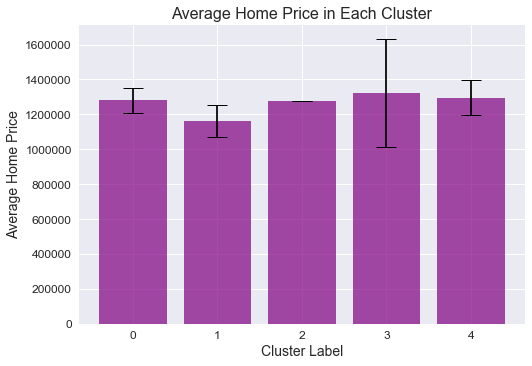

In [456]:
plt.bar(clusters_price_parks_cafes_yoga.index, clusters_price_parks_cafes_yoga["Average home price  (2017)", "mean"], 
       yerr=clusters_price_parks_cafes_yoga["Average home price  (2017)", "error"], align='center',
       alpha=0.7,
       ecolor="black",
       capsize=10, color="purple")
plt.title("Average Home Price in Each Cluster", fontsize=16)
plt.ylabel("Average Home Price", fontsize=14)
plt.xlabel("Cluster Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.style.use('seaborn')
# plt.rcParams.update({'lines.markeredgewidth': 1})
plt.show()

### Bar grath of average number of Parks, Coffee shops, and Yoga Studios by Cluster

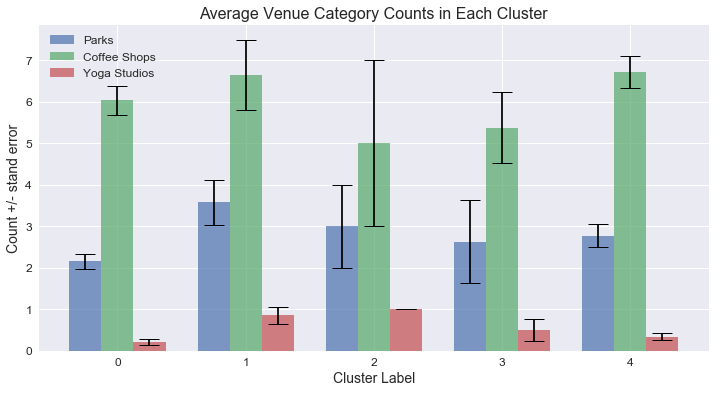

In [454]:
plt.figure(figsize=(12, 6))
width=0.25
plt.bar(clusters_price_parks_cafes_yoga.index-width, clusters_price_parks_cafes_yoga["Park", "mean"], width,           
       yerr=clusters_price_parks_cafes_yoga["Park", "error"], align='center',
       alpha=0.7,
       ecolor="black",
       capsize=10, label="Parks")
plt.bar(clusters_price_parks_cafes_yoga.index, clusters_price_parks_cafes_yoga["Coffee Shop", "mean"], width,
       yerr=clusters_price_parks_cafes_yoga["Coffee Shop", "error"], align='center',
       alpha=0.7,
       ecolor="black",
       capsize=10, label="Coffee Shops")
plt.bar(clusters_price_parks_cafes_yoga.index+width, clusters_price_parks_cafes_yoga["Yoga Studio", "mean"], width,
       yerr=clusters_price_parks_cafes_yoga["Yoga Studio", "error"], align='center',
       alpha=0.7,
       ecolor="black",
       capsize=10, label="Yoga Studios")
plt.title("Average Venue Category Counts in Each Cluster", fontsize=16)
plt.ylabel("Count +/- stand error", fontsize=14)
plt.xlabel("Cluster Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.show()

### Creating the new dataframe and display the top 10 venues for each neighborhood.

In [189]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [190]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues = pd.DataFrame(columns=columns)
top_venues['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    top_venues.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

top_venues.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0               Agincourt North           Coffee Shop     Indian Restaurant   
1  Agincourt South-Malvern West    Chinese Restaurant        Clothing Store   
2                     Alderwood           Coffee Shop      Department Store   
3                         Annex    Italian Restaurant           Coffee Shop   
4             Banbury-Don Mills           Coffee Shop   Japanese Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0        Sandwich Place    Chinese Restaurant        Discount Store   
1           Coffee Shop            Restaurant         Shopping Mall   
2            Restaurant          Burger Joint  Fast Food Restaurant   
3                  Park                  Café            Restaurant   
4           Supermarket    Italian Restaurant            Restaurant   

   6th Most Common Venue          7th Most Common Venue  \
0  Vietnamese Restaurant           Caribbean Restaurant   
1    Sporting Goods Shop                 Cosmetics Shop   
2                   Café              Electronics Store   
3                    Spa  Vegetarian / Vegan Restaurant   
4           Burger Joint                 Sandwich Place   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0             Supermarket                  Park            Pizza Place  
1                Tea Room                  Bank         Sandwich Place  
2  Furniture / Home Store           Pizza Place         Clothing Store  
3                   Hotel     French Restaurant    Japanese Restaurant  
4             Pizza Place                  Bank               Pharmacy

### Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [191]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
crime_top_venues_prices_cluster = crime_venues_prices_cluster.join(top_venues.set_index('Neighbourhood'), on='Neighbourhood').copy()
crime_top_venues_prices_cluster.head() # check the last columns!

Cluster Labels            Neighbourhood  Population  Size_of_hood_area  \
0               3           Yonge-St.Clair        3189       1.161315e+06   
1               0  York University Heights       36764       1.324666e+07   
2               0         Lansing-Westgate       10242       5.346186e+06   
3               0       Yorkdale-Glen Park       18233       6.038326e+06   
4               0      Stonegate-Queensway       22207       7.946202e+06   

    Latitude  Longitude  Assault_per_capita  AutoTheft_per_capita  \
0  43.688762 -79.399013            0.599812              0.678489   
1  43.759661 -79.499115            0.010211              0.001703   
2  43.753880 -79.422502            0.187805              0.020972   
3  43.717458 -79.452711            0.038200              0.008424   
4  43.636838 -79.496012            0.025956              0.008313   

   BreakandEnter_per_capita  Robbery_per_capita  Homicide_per_capita  \
0                  0.226152            0.186830             0.000000   
1                  0.003846            0.001110             0.000073   
2                  0.049570            0.039084             0.000000   
3                  0.016843            0.010530             0.000603   
4                  0.008313            0.007300             0.000000   

   Population_Density  ATM  Accessories Store  Afghan Restaurant  \
0            2.746026    0                  0                  0   
1            2.775342    0                  0                  0   
2            1.915758    0                  0                  0   
3            3.019546    0                  1                  0   
4            2.794669    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    3   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    2   
4                   0        0               0                    1   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   1   
1            0                    0                 0                   1   
2            0                    1                 0                   0   
3            0                    1                 0                   1   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          2           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          1           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           2       0     0    1               0                 0   
1           0       0     1    2               0                 0   
2           0       1     2    1               0                 0   
3           0       0     1    0               0                 0   
4           0       2     4    2               0                 0   

   Basketball Court  Basketball Stadium  Bath 

In [125]:
crime_top_venues_prices_cluster.columns[0:20]

Index(['Cluster Labels', 'Neighbourhood', 'Population', 'Size_of_hood_area',
       'Latitude', 'Longitude', 'Assault_per_capita', 'AutoTheft_per_capita',
       'BreakandEnter_per_capita', 'Robbery_per_capita', 'Homicide_per_capita',
       'Population_Density', 'Accessories Store', 'Afghan Restaurant',
       'African Restaurant', 'American Restaurant', 'Animal Shelter',
       'Antique Shop', 'Art Gallery', 'Arts & Crafts Store'],
      dtype='object')

In [193]:
crime_top_venues_prices_cluster.shape

(140, 370)

In [126]:
crime_top_venues_prices_cluster.columns[230:286]

Index(['South American Restaurant', 'Spa', 'Speakeasy', 'Sporting Goods Shop',
       'Sports Bar', 'Sports Club', 'Steakhouse', 'Storage Facility',
       'Supermarket', 'Sushi Restaurant', 'Syrian Restaurant', 'Taco Place',
       'Tapas Restaurant', 'Tea Room', 'Tennis Court', 'Tex-Mex Restaurant',
       'Thai Restaurant', 'Theater', 'Theme Park',
       'Theme Park Ride / Attraction', 'Tibetan Restaurant',
       'Toy / Game Store', 'Trail', 'Train Station', 'Transportation Service',
       'Tree', 'Turkish Restaurant', 'Vegetarian / Vegan Restaurant',
       'Video Store', 'Vietnamese Restaurant', 'Warehouse Store', 'Wine Bar',
       'Wings Joint', 'Women's Store', 'Yoga Studio', 'Zoo', 'Zoo Exhibit',
       'Average home price  (2017)', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common 

In [194]:
crime_top_venues_only_prices_cluster = crime_top_venues_prices_cluster[['Cluster Labels', 'Neighbourhood',
       'Population', 'Size_of_hood_area', 'Latitude',
       'Longitude', 'Assault_per_capita', 'AutoTheft_per_capita',
       'BreakandEnter_per_capita', 'Robbery_per_capita', 'Homicide_per_capita',
       'Population_Density', 'Average home price  (2017)',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']].copy()

In [195]:
crime_top_venues_prices_cluster.head()

Cluster Labels            Neighbourhood  Population  Size_of_hood_area  \
0               3           Yonge-St.Clair        3189       1.161315e+06   
1               0  York University Heights       36764       1.324666e+07   
2               0         Lansing-Westgate       10242       5.346186e+06   
3               0       Yorkdale-Glen Park       18233       6.038326e+06   
4               0      Stonegate-Queensway       22207       7.946202e+06   

    Latitude  Longitude  Assault_per_capita  AutoTheft_per_capita  \
0  43.688762 -79.399013            0.599812              0.678489   
1  43.759661 -79.499115            0.010211              0.001703   
2  43.753880 -79.422502            0.187805              0.020972   
3  43.717458 -79.452711            0.038200              0.008424   
4  43.636838 -79.496012            0.025956              0.008313   

   BreakandEnter_per_capita  Robbery_per_capita  Homicide_per_capita  \
0                  0.226152            0.186830             0.000000   
1                  0.003846            0.001110             0.000073   
2                  0.049570            0.039084             0.000000   
3                  0.016843            0.010530             0.000603   
4                  0.008313            0.007300             0.000000   

   Population_Density  ATM  Accessories Store  Afghan Restaurant  \
0            2.746026    0                  0                  0   
1            2.775342    0                  0                  0   
2            1.915758    0                  0                  0   
3            3.019546    0                  1                  0   
4            2.794669    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    3   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    2   
4                   0        0               0                    1   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   1   
1            0                    0                 0                   1   
2            0                    1                 0                   0   
3            0                    1                 0                   1   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          2           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          1           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           2       0     0    1               0                 0   
1           0       0     1    2               0                 0   
2           0       1     2    1               0                 0   
3           0       0     1    0               0                 0   
4           0       2     4    2               0                 0   

   Basketball Court  Basketball Stadium  Bath 

### Calculating the Average Normalized Crime Rate to represent all 5 crime types

In [199]:
crime_top_venues_only_prices_cluster["Average Crime"] = (
    crime_top_venues_prices_cluster['Assault_per_capita']/crime_top_venues_prices_cluster['Assault_per_capita'].max() +
    crime_top_venues_prices_cluster['AutoTheft_per_capita']/crime_top_venues_prices_cluster['AutoTheft_per_capita'].max() + 
    crime_top_venues_prices_cluster['BreakandEnter_per_capita']/crime_top_venues_prices_cluster['BreakandEnter_per_capita'].max() + 
    crime_top_venues_prices_cluster['Robbery_per_capita']/crime_top_venues_prices_cluster["Robbery_per_capita"].max() +
    crime_top_venues_prices_cluster['Homicide_per_capita']/crime_top_venues_prices_cluster["Homicide_per_capita"].max())/5

In [200]:
crime_top_venues_only_prices_cluster["Average Crime"] = crime_top_venues_only_prices_cluster["Average Crime"]*100

### Plotting Average Nprmalized crime rate as thr side of circles representing clustered neighourhoods

In [561]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, house_price in zip(crime_venues_prices_cluster['Latitude'], 
                                  crime_venues_prices_cluster['Longitude'], 
                                  crime_venues_prices_cluster['Neighbourhood'], 
                                  crime_venues_prices_cluster['Cluster Labels'],
                                       crime_top_venues_only_prices_cluster["Average Crime"]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=np.sqrt(house_price*5),
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)

folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.12)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),

        html='<div style="font-size: 12pt">Circle Area = Normalized crime rate </div>',
        )
    ).add_to(map_clusters)
       
map_clusters


### Dropping the 5 crime rate features to create a more concise summary of neighbourhoods

In [201]:
crime_top_venues_only_prices_cluster.drop(['Assault_per_capita', 'AutoTheft_per_capita',
       'BreakandEnter_per_capita', 'Robbery_per_capita', 'Homicide_per_capita'], axis=1, inplace=True)

In [202]:
crime_top_venues_only_prices_cluster.head()

Cluster Labels            Neighbourhood  Population  Size_of_hood_area  \
0               3           Yonge-St.Clair        3189       1.161315e+06   
1               0  York University Heights       36764       1.324666e+07   
2               0         Lansing-Westgate       10242       5.346186e+06   
3               0       Yorkdale-Glen Park       18233       6.038326e+06   
4               0      Stonegate-Queensway       22207       7.946202e+06   

    Latitude  Longitude  Population_Density  Average home price  (2017)  \
0  43.688762 -79.399013            2.746026                1.275567e+06   
1  43.759661 -79.499115            2.775342                2.621947e+06   
2  43.753880 -79.422502            1.915758                1.685373e+06   
3  43.717458 -79.452711            3.019546                9.409290e+05   
4  43.636838 -79.496012            2.794669                8.229920e+05   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    Italian Restaurant                  Café                  Park   
1           Coffee Shop           Pizza Place  Fast Food Restaurant   
2           Coffee Shop                  Park         Grocery Store   
3        Clothing Store           Coffee Shop  Fast Food Restaurant   
4           Coffee Shop    Italian Restaurant      Sushi Restaurant   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0             Coffee Shop      Sushi Restaurant            Restaurant   
1                Pharmacy    Falafel Restaurant        Tennis Stadium   
2                    Café         Deli / Bodega              Pharmacy   
3  Furniture / Home Store          Dessert Shop            Restaurant   
4                    Bank           Pizza Place                   Pub   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0   American Restaurant         Grocery Store          Liquor Store   
1   Japanese Restaurant         Grocery Store         Shopping Mall   
2           Pizza Place   Japanese Restaurant            Restaurant   
3         Grocery Store             Pet Store        Cosmetics Shop   
4                  Park                  Café          Dessert Shop   

  10th Most Common Venue  Average Crime  
0      French Restaurant      54.985073  
1                    Bar       0.627587  
2    Fried Chicken Joint       9.170891  
3       Sushi Restaurant       4.039170  
4                 Bakery       1.652471

### Exploring clusters

In [316]:
table_df =pd.DataFrame(crime_top_venues_only_prices_cluster.groupby('Cluster Labels', as_index=False)["Neighbourhood"].count())
table_df.rename(columns={"Neighbourhood": "Number of Neighbourhoods"})

Cluster Labels  Number of Neighbourhoods
0               0                        72
1               1                        14
2               2                         2
3               3                         8
4               4                        44

In [203]:
crime_top_venues_only_prices_cluster.loc[
    crime_top_venues_only_prices_cluster['Cluster Labels'] == 0, 
    crime_top_venues_only_prices_cluster.columns[[1] + 
    list(range(5, crime_top_venues_only_prices_cluster.shape[1]))]]["1st Most Common Venue"].value_counts()[0:10]

Coffee Shop             39
Fast Food Restaurant     7
Pizza Place              4
Park                     3
Chinese Restaurant       3
Greek Restaurant         2
Grocery Store            2
Clothing Store           2
Korean Restaurant        2
Café                     2
Name: 1st Most Common Venue, dtype: int64

In [204]:
crime_top_venues_only_prices_cluster.loc[
    crime_top_venues_only_prices_cluster['Cluster Labels'] == 4, 
    crime_top_venues_only_prices_cluster.columns[[1] + 
    list(range(5, crime_top_venues_only_prices_cluster.shape[1]))]]["1st Most Common Venue"].value_counts()[0:10]

Coffee Shop             18
Café                    10
Italian Restaurant       6
Fast Food Restaurant     2
Sushi Restaurant         1
Greek Restaurant         1
Park                     1
Korean Restaurant        1
Grocery Store            1
Chinese Restaurant       1
Name: 1st Most Common Venue, dtype: int64

In [205]:
crime_top_venues_only_prices_cluster.loc[
    crime_top_venues_only_prices_cluster['Cluster Labels'] == 1, 
    crime_top_venues_only_prices_cluster.columns[[1] + 
    list(range(5, crime_top_venues_only_prices_cluster.shape[1]))]]["1st Most Common Venue"].value_counts()[0:10]

Café                  5
Coffee Shop           3
Bar                   2
Italian Restaurant    2
Park                  1
Korean Restaurant     1
Name: 1st Most Common Venue, dtype: int64

### Exploring average Crime Rate and Population Density in each cluster

In [333]:
pop_crime_clusters = pd.DataFrame(
    crime_top_venues_only_prices_cluster.groupby(
        "Cluster Labels", as_index=False)[
        "Cluster Labels","Population_Density", "Average Crime"].describe())

In [334]:
pop_crime_clusters

Cluster Labels                                    Population_Density  \
           count mean  std  min  25%  50%  75%  max              count   
0           72.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0               72.0   
1           14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0               14.0   
2            2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0                2.0   
3            8.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0                8.0   
4           44.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0               44.0   

                                                                               \
        mean       std        min        25%        50%        75%        max   
0   3.391332  1.244026   0.839511   2.444675   3.545877   4.471487   5.184260   
1  13.359148  2.395544  10.846162  11.473040  12.708295  14.739712  18.633067   
2  29.301789  3.611492  26.748078  28.024933  29.301789  30.578644  31.855499   
3   2.543100  1.486470   1.199872   1.699717   2.270945   2.740525   5.932899   
4   7.158123  1.354413   5.311935   6.014834   7.094507   8.059822  10.047043   

  Average Crime                                                         \
          count       mean        std        min        25%        50%   
0          72.0   4.961064   5.126135   0.108411   0.917648   3.498047   
1          14.0   2.237054   2.189540   0.195973   0.512407   0.993215   
2           2.0   3.667911   4.020183   0.825212   2.246561   3.667911   
3           8.0  45.230260  11.164344  32.569354  37.787816  40.974270   
4          44.0   4.165014   5.267625   0.143958   0.898458   2.468118   

                         
         75%        max  
0   8.062445  20.472058  
1   3.847066   7.306593  
2   5.089260   6.510610  
3  55.533469  61.917481  
4   4.296778  24.956458

In [336]:
pop_crime_clusters["Population_Density", "error"] = pop_crime_clusters[
    "Population_Density", "std"]/ np.sqrt(pop_crime_clusters["Population_Density", "count"])
pop_crime_clusters["Average Crime", "error"] = pop_crime_clusters[
    "Average Crime", "std"]/ np.sqrt(pop_crime_clusters["Average Crime", "count"])

In [354]:
pop_crime_clusters

Cluster Labels                                    Population_Density  \
           count mean  std  min  25%  50%  75%  max              count   
0           72.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0               72.0   
1           14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0               14.0   
2            2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0                2.0   
3            8.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0                8.0   
4           44.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0               44.0   

                                                                               \
        mean       std        min        25%        50%        75%        max   
0   3.391332  1.244026   0.839511   2.444675   3.545877   4.471487   5.184260   
1  13.359148  2.395544  10.846162  11.473040  12.708295  14.739712  18.633067   
2  29.301789  3.611492  26.748078  28.024933  29.301789  30.578644  31.855499   
3   2.543100  1.486470   1.199872   1.699717   2.270945   2.740525   5.932899   
4   7.158123  1.354413   5.311935   6.014834   7.094507   8.059822  10.047043   

  Average Crime                                                         \
          count       mean        std        min        25%        50%   
0          72.0   4.961064   5.126135   0.108411   0.917648   3.498047   
1          14.0   2.237054   2.189540   0.195973   0.512407   0.993215   
2           2.0   3.667911   4.020183   0.825212   2.246561   3.667911   
3           8.0  45.230260  11.164344  32.569354  37.787816  40.974270   
4          44.0   4.165014   5.267625   0.143958   0.898458   2.468118   

                        Population_Density Average Crime  
         75%        max              error         error  
0   8.062445  20.472058           0.146610      0.604121  
1   3.847066   7.306593           0.640236      0.585179  
2   5.089260   6.510610           2.553710      2.842699  
3  55.533469  61.917481           0.525547      3.947192  
4   4.296778  24.956458           0.204185      0.794124

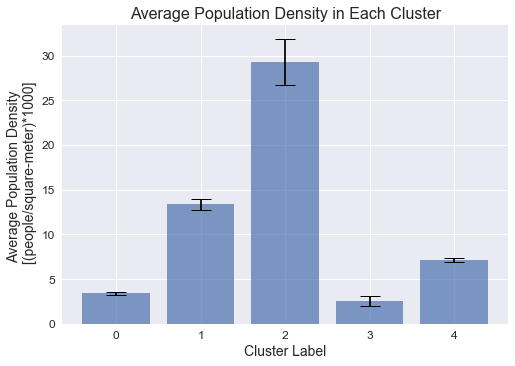

In [388]:
plt.bar(pop_crime_clusters.index, pop_crime_clusters["Population_Density", "mean"], 
       yerr=pop_crime_clusters["Population_Density", "error"], align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10)
plt.title("Average Population Density in Each Cluster", fontsize=16)
plt.ylabel("Average Population Density \n [(people/square-meter)*1000]", fontsize=14)
plt.xlabel("Cluster Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.style.use('seaborn')
# plt.rcParams.update({'lines.markeredgewidth': 1})
plt.show()

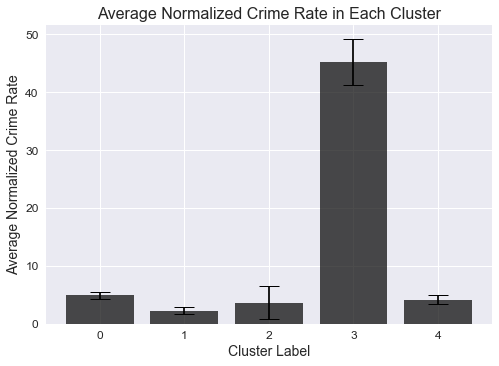

In [391]:
plt.bar(pop_crime_clusters.index, pop_crime_clusters["Average Crime", "mean"], 
       yerr=pop_crime_clusters["Average Crime", "error"], align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, color="black")
plt.title("Average Normalized Crime Rate in Each Cluster", fontsize=16)
plt.ylabel("Average Normalized Crime Rate", fontsize=14)
plt.xlabel("Cluster Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.style.use('seaborn')
# plt.rcParams.update({'lines.markeredgewidth': 1})
plt.show()

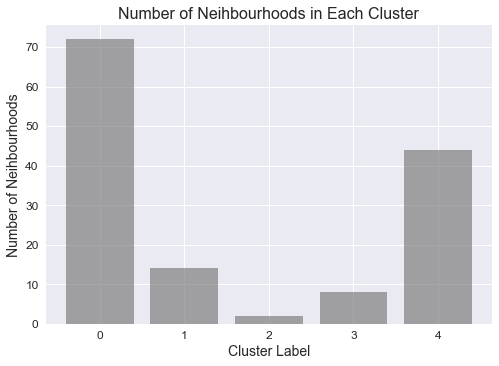

In [395]:
plt.bar(pop_crime_clusters.index, pop_crime_clusters["Average Crime", "count"], 
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, color="grey")
plt.title("Number of Neihbourhoods in Each Cluster", fontsize=16)
plt.ylabel("Number of Neihbourhoods", fontsize=14)
plt.xlabel("Cluster Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.style.use('seaborn')
# plt.rcParams.update({'lines.markeredgewidth': 1})
plt.show()

### Exploring Cluster "0". Filtering out neighbourhoods that have an average home price of greater than $800,000, and a crime rate of greater than 4. 

In [563]:
crime_top_venues_prices_cluster[crime_top_venues_prices_cluster['Neighbourhood'] == "Forest Hill South"]["Average home price  (2017)"]

54    1319395.0
Name: Average home price  (2017), dtype: float64

In [564]:
crime_top_venues_prices_cluster[crime_top_venues_prices_cluster['Neighbourhood'] == "Forest Hill South"]["Population_Density"]

54    5.014873
Name: Population_Density, dtype: float64

In [565]:
hoods_fit_for_me = crime_top_venues_only_prices_cluster[(
    crime_top_venues_prices_cluster['Cluster Labels'] == 0) & 
    (crime_top_venues_prices_cluster["Average home price  (2017)"] < 800000.0)].drop(
    ["Size_of_hood_area", '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'], axis=1)

In [566]:
hoods_fit_for_me.columns

Index(['Cluster Labels', 'Neighbourhood', 'Population', 'Latitude',
       'Longitude', 'Population_Density', 'Average home price  (2017)',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', 'Average Crime'],
      dtype='object')

In [567]:
hoods_fit_for_me = hoods_fit_for_me[['Neighbourhood',  'Population_Density', 'Average Crime', 
                                     'Average home price  (2017)',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', 'Latitude',
       'Longitude']]

In [568]:
hoods_fit_for_me

Neighbourhood  Population_Density  Average Crime  \
19            Humber Summit            1.780867       2.251131   
20               Humbermede            1.363514       7.374925   
34   Glenfield-Jane Heights            5.074424       1.547167   
43             Kennedy Park            5.083607       6.414137   
77            Eglinton East            1.956474       9.094528   
83               L'Amoreaux            4.154920       0.529240   
89    Birchcliffe-Cliffside            4.332918       0.846891   
94              Black Creek            4.991857      20.217846   
111                  Woburn            2.830533       0.206713   
118                  Weston            4.452868       4.539476   
122                 Malvern            4.042411       0.872694   

     Average home price  (2017) 1st Most Common Venue 2nd Most Common Venue  \
19                     706722.0           Coffee Shop                  Bank   
20                     772315.0           Coffee Shop  Fast Food Restaurant   
34                     745701.0           Pizza Place         Grocery Store   
43                     729499.0         Grocery Store           Coffee Shop   
77                     631198.0  Fast Food Restaurant        Sandwich Place   
83                     784794.0  Fast Food Restaurant    Chinese Restaurant   
89                     725980.0           Coffee Shop       Thai Restaurant   
94                     730270.0           Coffee Shop  Fast Food Restaurant   
111                    746787.0  Fast Food Restaurant           Coffee Shop   
118                    729035.0  Fast Food Restaurant           Pizza Place   
122                    692097.0  Fast Food Restaurant              Pharmacy   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
19                    Park      Asian Restaurant        Hardware Store   
20       Indian Restaurant  Caribbean Restaurant           Pizza Place   
34   Vietnamese Restaurant  Fast Food Restaurant           Coffee Shop   
43                Pharmacy        Discount Store    Chinese Restaurant   
77             Pizza Place              Pharmacy         Grocery Store   
83             Coffee Shop              Pharmacy        Sandwich Place   
89             Golf Course          Liquor Store            Beer Store   
94             Pizza Place                 Hotel   Japanese Restaurant   
111     Chinese Restaurant           Pizza Place                  Bank   
118            Coffee Shop        Sandwich Place         Grocery Store   
122            Pizza Place         Grocery Store        Sandwich Place   

      Latitude  Longitude  
19   43.756657 -79.570138  
20   43.741473 -79.551884  
34   43.745591 -79.505161  
43   43.726791 -79.260034  
77   43.743029 -79.245636  
83   43.791460 -79.309635  
89   43.688760 -79.262795  
94   43.765908 -79.513970  
111  43.765936 -79.223175  
118  43.703800 -79.522170  
122  43.803431 -79.222301

#### Plotting the 11 neighbourhoods in Cluster 0 that have an average home price of less than $800,000

In [570]:
# create map of New York using latitude and longitude values
toronto_hood_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, crime in zip(hoods_fit_for_me['Latitude'], 
                                              hoods_fit_for_me['Longitude'], 
                                              hoods_fit_for_me['Neighbourhood'],
                                             hoods_fit_for_me['Average Crime']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=np.sqrt(crime*50),
        popup=label,
        color='black',
        fill=True,
        fill_color='grey',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_hood_map)  

folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.04)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),
        html='<div style="font-size: 12pt">Circle Area = Normalized crime rate (Home price < 800k) </div>',
        )
    ).add_to(toronto_hood_map)
    
toronto_hood_map

In [571]:
hoods_fit_for_me = hoods_fit_for_me[hoods_fit_for_me['Average Crime'] < 4]

# Plotting and summarizing the winners: 6 neighbourhoods from Clsuter 0 than have an average home price of less than $800,000 and a normalized crime rate of less than 4.

In [573]:
# create map of New York using latitude and longitude values
toronto_hood_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, crime in zip(hoods_fit_for_me['Latitude'], 
                                              hoods_fit_for_me['Longitude'], 
                                              hoods_fit_for_me['Neighbourhood'],
                                             hoods_fit_for_me['Average Crime']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=np.sqrt(crime*50),
        popup=label,
        color='black',
        fill=True,
        fill_color='grey',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_hood_map)  
    
folium.map.Marker(
    [(43.694286-0.09), (-79.412848+.10)],
    icon=DivIcon(
        icon_size=(1000,100),
        icon_anchor=(0,0),
        html='<div style="font-size: 12pt">Circle Area = Normalized crime rate (< 4) </div>',
        )
    ).add_to(toronto_hood_map)
    
toronto_hood_map

In [574]:
hoods_fit_for_me

Neighbourhood  Population_Density  Average Crime  \
19            Humber Summit            1.780867       2.251131   
34   Glenfield-Jane Heights            5.074424       1.547167   
83               L'Amoreaux            4.154920       0.529240   
89    Birchcliffe-Cliffside            4.332918       0.846891   
111                  Woburn            2.830533       0.206713   
122                 Malvern            4.042411       0.872694   

     Average home price  (2017) 1st Most Common Venue 2nd Most Common Venue  \
19                     706722.0           Coffee Shop                  Bank   
34                     745701.0           Pizza Place         Grocery Store   
83                     784794.0  Fast Food Restaurant    Chinese Restaurant   
89                     725980.0           Coffee Shop       Thai Restaurant   
111                    746787.0  Fast Food Restaurant           Coffee Shop   
122                    692097.0  Fast Food Restaurant              Pharmacy   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
19                    Park      Asian Restaurant        Hardware Store   
34   Vietnamese Restaurant  Fast Food Restaurant           Coffee Shop   
83             Coffee Shop              Pharmacy        Sandwich Place   
89             Golf Course          Liquor Store            Beer Store   
111     Chinese Restaurant           Pizza Place                  Bank   
122            Pizza Place         Grocery Store        Sandwich Place   

      Latitude  Longitude  
19   43.756657 -79.570138  
34   43.745591 -79.505161  
83   43.791460 -79.309635  
89   43.688760 -79.262795  
111  43.765936 -79.223175  
122  43.803431 -79.222301

In [516]:
np.array(hoods_fit_for_me["Neighbourhood"])

array(['Humber Summit', 'Glenfield-Jane Heights', "L'Amoreaux",
       'Birchcliffe-Cliffside', 'Woburn', 'Malvern'], dtype=object)

# The End!